[View in Colaboratory](https://colab.research.google.com/github/Con-Mi/Deep-Learning-Projects/blob/master/Comparing_Transpose_Convolution_with_regular_Convolution_for_Classification_using_Densely_Connected_Convolutional_Networks.ipynb)

## Check my blog post [here](https://goosemi.wordpress.com/) for a more detail explanation of this model.

In [1]:
# Install PyTorch(version 4) and torchvision libraries
!pip install torch torchvision

    100% |████████████████████████████████| 484.0MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5c120000 @  0x7f8f217391c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 8.5MB/s 
    100% |████████████████████████████████| 2.0MB 2.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
import gc
#Garbage Collector
gc.collect()

291

In [3]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [0]:
"""
	The Network Class
"""

import torch
import torch.nn as nn
import math

class Dense_Block_Transposed(nn.Module):
	def __init__(self, in_channels):
		super(Dense_Block_Transposed, self).__init__()

		self.relu = nn.LeakyReLU(inplace = True)
		self.bn = nn.BatchNorm2d(num_features = in_channels)
    

		self.conv1 = nn.ConvTranspose2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv4 = nn.ConvTranspose2d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv5 = nn.ConvTranspose2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)

    
	def forward(self, x):

		bn = self.bn(x)
		conv1 = self.relu(self.conv1(bn))

		conv2 = self.relu(self.conv2(conv1))
		c2_dense = self.relu(torch.cat([conv1, conv2], 1))

		conv3 = self.relu(self.conv3(c2_dense))
		c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))

		conv4 = self.relu(self.conv4(c3_dense))
		c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))

		conv5 = self.relu(self.conv5(c4_dense))
		c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))

		return c5_dense


class Transition_Layer_Transposed(nn.Module):
	def __init__(self, in_channels, out_channels):
		super(Transition_Layer_Transposed, self).__init__()

		self.relu = nn.LeakyReLU(inplace = True)
		self.bn = nn.BatchNorm2d(num_features = out_channels)
		self.conv = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, bias = False)
		self.avg_pool = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0)

	def forward(self, x):

		bn = self.bn(self.relu(self.conv(x)))
		out = self.avg_pool(bn)

		return out


class DenseNetTransposed(nn.Module):
	def __init__(self, nr_classes):
		super(DenseNetTransposed, self).__init__()

		self.lowconv = nn.ConvTranspose2d(in_channels = 3, out_channels = 64, kernel_size = 7, padding = 3, bias = False)
		self.relu = nn.LeakyReLU(inplace = True)

		# Make Dense Blocks
		self.denseblock1 = self._make_dense_block(Dense_Block_Transposed, 64)
		self.denseblock2 = self._make_dense_block(Dense_Block_Transposed, 128)
		self.denseblock3 = self._make_dense_block(Dense_Block_Transposed, 128)

		# Make transition Layers
		self.transitionLayer1 = self._make_transition_layer(Transition_Layer_Transposed, in_channels = 160, out_channels = 128)
		self.transitionLayer2 = self._make_transition_layer(Transition_Layer_Transposed, in_channels = 160, out_channels = 128)
		self.transitionLayer3 = self._make_transition_layer(Transition_Layer_Transposed, in_channels = 160, out_channels = 64)

		# Classifier
		self.bn = nn.BatchNorm2d(num_features = 64)
		self.pre_classifier = nn.Linear(64*4*4, 512)
		self.classifier = nn.Linear(512, nr_classes)

	def _make_dense_block(self, block, in_channels):
		layers = []
		layers.append(block(in_channels))
		return nn.Sequential(*layers)

	def _make_transition_layer(self, layer, in_channels, out_channels):
		modules = []
		modules.append(layer(in_channels, out_channels))
		return nn.Sequential(*modules)

	def forward(self, x):
		out = self.relu(self.lowconv(x))

		out = self.denseblock1(out)
		out = self.transitionLayer1(out)

		out = self.denseblock2(out)
		out = self.transitionLayer2(out)

		out = self.denseblock3(out)
		out = self.transitionLayer3(out)
    
		out = self.bn(out)
		out = out.view(-1, 64*4*4)

		out = self.pre_classifier(out)
		out = self.classifier(out)

		return out


In [5]:
import time
import torch.optim as optim
from torch.autograd import Variable

# GPU flag
use_gpu = torch.cuda.is_available()

# Hyperparameters
batch_size = 10
momentum = 0.92
learning_rate = 0.0001
nr_classes = 10
nr_epochs = 60
loss_vctr_trnsps = []

# Load the model on the GPU
densenet_trnsps = DenseNetTransposed(nr_classes)
if use_gpu:
  densenet_trnsps.cuda()

# Data Loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

start = time.time()

# Oprimization Criteria and Optimization method
criterion = nn.CrossEntropyLoss().cuda() if use_gpu else nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet_trnsps.parameters(), lr=learning_rate, momentum=momentum, nesterov = False)

# Training Loop
print("Start of the Optimization Processs..")
for epoch in range(nr_epochs):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = Variable(inputs).cuda() 
        labels = Variable(labels).cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = densenet_trnsps(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            loss_vctr_trnsps.append(running_loss / 2000)
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    
print("^^^^^^^^^^^^^^^^^")
print('Finished Optimization.')
end = time.time() # Time counted in seconds
print("The total time to train the model on the K80 GPU is : {:.1f} minutes.".format((end - start)/60))

Start of the Optimization Processs..
[1,  2000] loss: 1.705589
[1,  4000] loss: 1.344412
[2,  2000] loss: 1.110875
[2,  4000] loss: 1.027956
[3,  2000] loss: 0.901889
[3,  4000] loss: 0.871348
[4,  2000] loss: 0.783466
[4,  4000] loss: 0.770353
[5,  2000] loss: 0.703065
[5,  4000] loss: 0.696938
[6,  2000] loss: 0.626112
[6,  4000] loss: 0.639383
[7,  2000] loss: 0.574428
[7,  4000] loss: 0.578986
[8,  2000] loss: 0.516113
[8,  4000] loss: 0.540924
[9,  2000] loss: 0.478360
[9,  4000] loss: 0.506130
[10,  2000] loss: 0.436833
[10,  4000] loss: 0.466854
[11,  2000] loss: 0.405612
[11,  4000] loss: 0.428128
[12,  2000] loss: 0.365128
[12,  4000] loss: 0.392070
[13,  2000] loss: 0.338236
[13,  4000] loss: 0.365915
[14,  2000] loss: 0.312871
[14,  4000] loss: 0.342255
[15,  2000] loss: 0.285024
[15,  4000] loss: 0.310282
[16,  2000] loss: 0.254327
[16,  4000] loss: 0.286868
[17,  2000] loss: 0.228580
[17,  4000] loss: 0.260366
[18,  2000] loss: 0.200980
[18,  4000] loss: 0.234784
[19,  200

[43,  2000] loss: 0.026131
[43,  4000] loss: 0.026552
[44,  2000] loss: 0.024227
[44,  4000] loss: 0.028621
[45,  2000] loss: 0.022489
[45,  4000] loss: 0.019383
[46,  2000] loss: 0.019862
[46,  4000] loss: 0.033631
[47,  2000] loss: 0.025278
[47,  4000] loss: 0.024051
[48,  2000] loss: 0.021003
[48,  4000] loss: 0.023745
[49,  2000] loss: 0.024363
[49,  4000] loss: 0.023130
[50,  2000] loss: 0.024271
[50,  4000] loss: 0.029729
[51,  2000] loss: 0.025193
[51,  4000] loss: 0.032065
[52,  2000] loss: 0.026527
[52,  4000] loss: 0.029387
[53,  2000] loss: 0.027078
[53,  4000] loss: 0.027771
[54,  2000] loss: 0.024706
[54,  4000] loss: 0.021626
[55,  2000] loss: 0.027011
[55,  4000] loss: 0.019568
[56,  2000] loss: 0.014024
[56,  4000] loss: 0.015649
[57,  2000] loss: 0.011608
[57,  4000] loss: 0.009887
[58,  2000] loss: 0.007497
[58,  4000] loss: 0.007812
[59,  2000] loss: 0.007108
[59,  4000] loss: 0.006725
[60,  2000] loss: 0.007925
[60,  4000] loss: 0.007022
^^^^^^^^^^^^^^^^^
Finished O

In [6]:
# Garbage collector
gc.collect()

319

In [0]:

"""
 	The Network Class with regular convolutions
"""

import torch
import torch.nn as nn
import math

class Dense_Block(nn.Module):
	def __init__(self, in_channels):
		super(Dense_Block, self).__init__()

		self.relu = nn.LeakyReLU(inplace = True)
		self.bn = nn.BatchNorm2d(num_features = in_channels)

		self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv4 = nn.Conv2d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)

    
	def forward(self, x):

		bn = self.bn(x)
		conv1 = self.relu(self.conv1(bn))

		conv2 = self.relu(self.conv2(conv1))
		c2_dense = self.relu(torch.cat([conv1, conv2], 1))

		conv3 = self.relu(self.conv3(c2_dense))
		c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))

		conv4 = self.relu(self.conv4(c3_dense))
		c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))

		conv5 = self.relu(self.conv5(c4_dense))
		c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))

		return c5_dense


class Transition_Layer(nn.Module):
	def __init__(self, in_channels, out_channels):
		super(Transition_Layer, self).__init__()

		self.relu = nn.LeakyReLU(inplace = True)
		self.bn = nn.BatchNorm2d(num_features = out_channels)
		self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, bias = False)
		self.avg_pool = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0)

	def forward(self, x):

		bn = self.bn(self.relu(self.conv(x)))
		out = self.avg_pool(bn)

		return out


class DenseNet(nn.Module):
	def __init__(self, nr_classes):
		super(DenseNet, self).__init__()

		self.lowconv = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, padding = 3, bias = False)
		self.relu = nn.LeakyReLU(inplace = True)

		# Make Dense Blocks
		self.denseblock1 = self._make_dense_block(Dense_Block, 64)
		self.denseblock2 = self._make_dense_block(Dense_Block, 128)
		self.denseblock3 = self._make_dense_block(Dense_Block, 128)

		# Make transition Layers
		self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128)
		self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128)
		self.transitionLayer3 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64)

		# Classifier
		self.bn = nn.BatchNorm2d(num_features = 64)
		self.pre_classifier = nn.Linear(64*4*4, 512)
		self.classifier = nn.Linear(512, nr_classes)

	def _make_dense_block(self, block, in_channels):
		layers = []
		layers.append(block(in_channels))
		return nn.Sequential(*layers)

	def _make_transition_layer(self, layer, in_channels, out_channels):
		modules = []
		modules.append(layer(in_channels, out_channels))
		return nn.Sequential(*modules)

	def forward(self, x):
		out = self.relu(self.lowconv(x))

		out = self.denseblock1(out)
		out = self.transitionLayer1(out)

		out = self.denseblock2(out)
		out = self.transitionLayer2(out)

		out = self.denseblock3(out)
		out = self.transitionLayer3(out)
    
		out = self.bn(out)
		out = out.view(-1, 64*4*4)

		out = self.pre_classifier(out)
		out = self.classifier(out)

		return out

In [9]:
loss_vctr = []
densenet = DenseNet(nr_classes)
if use_gpu:
  densenet.cuda()

start = time.time()

# Oprimization Criteria and Optimization method
criterion1 = nn.CrossEntropyLoss().cuda() if use_gpu else nn.CrossEntropyLoss()
optimizer1 = optim.SGD(densenet.parameters(), lr=learning_rate, momentum=momentum, nesterov = False)

# Training Loop
print("Start of the Optimization Processs..")
for epoch in range(nr_epochs):  

    running_loss1 = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = Variable(inputs).cuda() 
        labels = Variable(labels).cuda()
        
        # zero the parameter gradients
        optimizer1.zero_grad()

        # forward + backward + optimize
        outputs1 = densenet(inputs)
        loss1 = criterion1(outputs1, labels)
        loss1.backward()
        optimizer1.step()

        # print statistics
        running_loss1 += loss1.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            loss_vctr.append(running_loss1 / 2000)
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss1 / 2000))
            running_loss1 = 0.0
    
print("^^^^^^^^^^^^^^^^^")
print('Finished Optimization.')
end = time.time() # Time counted in seconds
print("The total time to train the model on the K80 GPU is : {:.1f} minutes.".format((end - start)/60))

Start of the Optimization Processs..
[1,  2000] loss: 1.721880
[1,  4000] loss: 1.368949
[2,  2000] loss: 1.132719
[2,  4000] loss: 1.037682
[3,  2000] loss: 0.915579
[3,  4000] loss: 0.876902
[4,  2000] loss: 0.787436
[4,  4000] loss: 0.766910
[5,  2000] loss: 0.704700
[5,  4000] loss: 0.707645
[6,  2000] loss: 0.639174
[6,  4000] loss: 0.633244
[7,  2000] loss: 0.572925
[7,  4000] loss: 0.601752
[8,  2000] loss: 0.523357
[8,  4000] loss: 0.549880
[9,  2000] loss: 0.488107
[9,  4000] loss: 0.510672
[10,  2000] loss: 0.447557
[10,  4000] loss: 0.472651
[11,  2000] loss: 0.419125
[11,  4000] loss: 0.436700
[12,  2000] loss: 0.382186
[12,  4000] loss: 0.406234
[13,  2000] loss: 0.337551
[13,  4000] loss: 0.382120
[14,  2000] loss: 0.323883
[14,  4000] loss: 0.346175
[15,  2000] loss: 0.287486
[15,  4000] loss: 0.318435
[16,  2000] loss: 0.260553
[16,  4000] loss: 0.295234
[17,  2000] loss: 0.244508
[17,  4000] loss: 0.262450
[18,  2000] loss: 0.229094
[18,  4000] loss: 0.245431
[19,  200

[43,  2000] loss: 0.033733
[43,  4000] loss: 0.036785
[44,  2000] loss: 0.023468
[44,  4000] loss: 0.027815
[45,  2000] loss: 0.025987
[45,  4000] loss: 0.029791
[46,  2000] loss: 0.025484
[46,  4000] loss: 0.032742
[47,  2000] loss: 0.024315
[47,  4000] loss: 0.024484
[48,  2000] loss: 0.020246
[48,  4000] loss: 0.020302
[49,  2000] loss: 0.013789
[49,  4000] loss: 0.017458
[50,  2000] loss: 0.014889
[50,  4000] loss: 0.016084
[51,  2000] loss: 0.011991
[51,  4000] loss: 0.013800
[52,  2000] loss: 0.007589
[52,  4000] loss: 0.009840
[53,  2000] loss: 0.008995
[53,  4000] loss: 0.009027
[54,  2000] loss: 0.009584
[54,  4000] loss: 0.006561
[55,  2000] loss: 0.004871
[55,  4000] loss: 0.005880
[56,  2000] loss: 0.004763
[56,  4000] loss: 0.005576
[57,  2000] loss: 0.003585
[57,  4000] loss: 0.003564
[58,  2000] loss: 0.004086
[58,  4000] loss: 0.004891
[59,  2000] loss: 0.003812
[59,  4000] loss: 0.002728
[60,  2000] loss: 0.002489
[60,  4000] loss: 0.002745
^^^^^^^^^^^^^^^^^
Finished O

In [10]:
gc.collect()

3065

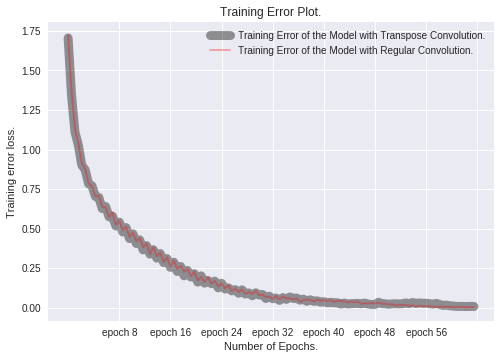

In [24]:
from matplotlib import pyplot as plt
import numpy as np

x = range(120)
x_epoch = [z for z in range(1, 121) if z%15 == 0]
x_ticks_labels = ['epoch ' + str(x) for x in range(1, 61) if x%8 == 0]

plt.figure(1)
plt.plot(x, loss_vctr_trnsps, color = 'k', label = "Training Error of the Model with Transpose Convolution.", linewidth = 9, alpha = 0.4)
plt.plot(x, loss_vctr, color = 'r', label = "Training Error of the Model with Regular Convolution.", linewidth = 2, alpha = 0.3)
plt.xticks(x_epoch, x_ticks_labels)
plt.title("Training Error Plot.")
plt.ylabel("Training error loss.")
plt.xlabel("Number of Epochs.")
plt.legend()
# plt.savefig("training_plot.png", dpi = 300)  If you want to save your plot, uncomment.
plt.show()

In [13]:
correct = 0
total = 0

for data in testloader:
        images, labels = data
        images = Variable(images).cuda()
        outputs = densenet_trnsps(images)
        _, predicted = torch.max(outputs.cpu().data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
print('Accuracy of the Network with ^Transpose^ Convolutions on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the Network with ^Transpose^ Convolutions on the 10000 test images: 79 %


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = densenet_trnsps(images.cuda())
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


print("Accuracy of the Network with ^Transpose^ Convolutions on each individual class:")
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

Accuracy of the Network with ^Transpose^ Convolutions on each individual class:
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Accuracy of plane : 84 %
Accuracy of   car : 89 %
Accuracy of  bird : 67 %
Accuracy of   cat : 60 %
Accuracy of  deer : 76 %
Accuracy of   dog : 74 %
Accuracy of  frog : 83 %
Accuracy of horse : 80 %
Accuracy of  ship : 89 %
Accuracy of truck : 88 %
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [17]:
correct1 = 0
total1 = 0

for data in testloader:
        images, labels = data
        images = Variable(images).cuda()
        outputs1 = densenet(images)
        _, predicted1 = torch.max(outputs1.cpu().data, 1)
        total1 += labels.size(0)
        correct1 += (predicted1 == labels).sum()
        
print('Accuracy of the Network with ^Regular^ Convolutions on the 10000 test images: %d %%' % (
    100 * correct1 / total1))

Accuracy of the Network with ^Regular^ Convolutions on the 10000 test images: 79 %


In [18]:
class_correct1 = list(0. for i in range(10))
class_total1 = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = densenet(images.cuda())
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct1[label] += c[i].item()
            class_total1[label] += 1

print("Accuracy of the Network with ^Regular^ Convolutions on each individual class:")
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

Accuracy of the Network with ^Regular^ Convolutions on each individual class:
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Accuracy of plane : 85 %
Accuracy of   car : 88 %
Accuracy of  bird : 72 %
Accuracy of   cat : 62 %
Accuracy of  deer : 71 %
Accuracy of   dog : 72 %
Accuracy of  frog : 83 %
Accuracy of horse : 79 %
Accuracy of  ship : 88 %
Accuracy of truck : 86 %
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
